In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

# adding normal distributed noise to image
def add_noise(img, mean=0, sigma=0.3):
    noisy_img = img + torch.normal(mean * torch.ones(img.shape), sigma)
    return noisy_img.clamp(0,1)

# function to count model parameters that are adjusted during training
def model_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# evaluation function for specified dataset
def eval_model(model, data_loader, criterion, device):
  with torch.no_grad():
      model.eval()

      loss_list = []
      loss_recons = []
      loss_kld = []

      for images, labels in data_loader:
          nimages = add_noise(images)
          nimages = nimages.to(device)
          images = images.to(device)

          outputs, (z, mu, log_var) = model(nimages)

          loss, (recons_l, kld_l) = criterion(outputs, images, mu, log_var)
          loss_list.append(loss.item())
          loss_recons.append(recons_l.cpu().numpy())
          loss_kld.append(kld_l.cpu().numpy())

      loss = np.mean(loss_list)
      recons = np.mean(loss_recons)
      kld = np.mean(loss_kld)

      model.train()
      return loss, (recons, kld)



#
from tqdm import tqdm

def train(model, NUM_EPOCHS, train_loader,train_loader1, test_loader, optimizer, criterion, EVAL_FREQ, SAVE_FREQ, savepath, device, scheduler, twriter = None, loadpath = None, stats = None):

  if loadpath != None:
    model, optimizer, init_epoch, stats = load_model(model, optimizer, loadpath)
    print('loaded model: ' + loadpath)
  elif stats != None:
     stats = stats
     init_epoch = 0
  else:
    stats = {
    "epoch": [],
    "full_train_loss": [],
    "train_loss": [],
    "valid_loss": [],
    "valid_loss_recons": [],
    "valid_loss_kld": [],
    "per_batch_loss": [],
    }
    init_epoch = 0

  model.to(device)
  model.train()

  loss_hist = []
  best_acc = 0

  valid_loss, (recons, kld) = eval_model(model, test_loader, criterion, device)

  stats["valid_loss"].append(valid_loss)
  stats["valid_loss_recons"].append(recons)
  stats["valid_loss_kld"].append(kld)

  if len(stats["epoch"]) == 0:
      stats["epoch"].append(0)
  else:
      stats["epoch"].append(stats["epoch"][-1]+1)
  print(f"Epoch -1: valid_loss {valid_loss:.5f}")# | lr {current_lr}")

  for epoch in range(init_epoch, NUM_EPOCHS):
      loss_list = []
      progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
      for i, (images, labels) in progress_bar:
          nimages = add_noise(images)
          images = images.to(device)
          nimages = nimages.to(device)
          optimizer.zero_grad()

          outputs, (z, mu, log_var) = model(nimages)
          loss, _ = criterion(outputs, images, mu, log_var)
          loss_list.append(loss.item())
          stats["per_batch_loss"].append(loss.cpu().detach().numpy())

          loss.backward()

          optimizer.step()

          progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")

      loss_hist.append(np.mean(loss_list))
      stats["epoch"].append(stats["epoch"][-1]+1)
      stats["full_train_loss"].append(loss_hist[-1])
      if twriter != None:
         twriter.add_scalar(f'Full Loss', stats["full_train_loss"][-1], global_step=stats["epoch"][-1])

      if epoch % EVAL_FREQ == 0:
          valid_loss, (recons, kld) = eval_model(model, test_loader, criterion, device)
          stats["valid_loss"].append(valid_loss)
          stats["valid_loss_recons"].append(recons)
          stats["valid_loss_kld"].append(kld)
          if twriter != None:
            twriter.add_scalar(f'Loss/Valid', valid_loss, global_step=stats["epoch"][-1])

          print(f"Epoch {epoch+1}: train_loss {np.mean(loss_list):.5f} | valid_loss {valid_loss:.5f}")#| lr {current_lr}")


      if epoch % SAVE_FREQ == 0:
          save_model(model=model, optimizer=optimizer, epoch=epoch, stats=stats, path=savepath, best=False)

      scheduler.step(stats["valid_loss"][-1])


  return stats, model

# function to make loss smooth
def smooth(f, K=5):
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]
    return smooth_f


# functions to save model/stats and load them
import os

def save_model(model, optimizer, epoch, stats, path, best=False):
    if(not os.path.exists(path + "/models")):
        os.makedirs(path + "/models")
    if best:
        savepath = path + '/' + f"models/best_model.pth"
    else:
        savepath = path + '/' + f"models/checkpoint_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    return


def load_model(model, optimizer, savepath):

    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]

    return model, optimizer, epoch, stats


# function to evaluate cnn model and plot results
def eval_plots(model, test_loader, criterion, device, stats):
  eval_loss, (recons, kld) = eval_model(model, test_loader, criterion, device)

  epochs = np.array(stats["epoch"])-1
  train_loss = np.array(stats["full_train_loss"])
  valid_loss = np.array(stats["valid_loss"])
  rec_loss = np.array(stats["valid_loss_recons"])
  kld_loss = np.array(stats["valid_loss_kld"])

  # show loss curves and accuracy
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))

  ax[0].plot(train_loss, label="train loss")
  ax[0].plot(epochs, valid_loss, label="valid loss")
  ax[0].set_xlabel("Epoch")
  ax[0].set_ylabel("Loss")
  ax[0].set_title("Loss curves (train/validation)")
  ax[0].legend()
  ax[0].grid()

  ax[1].plot(epochs, valid_loss, label="total loss")
  ax[1].plot(epochs, rec_loss, label="recons loss")
  ax[1].plot(epochs, kld_loss, label="KLD loss")
  ax[1].set_xlabel("Epoch")
  ax[1].set_ylabel("Loss")
  ax[1].set_title("Independent Loss Curves")
  ax[1].legend()
  ax[1].set_yscale("log")
  ax[1].grid()



  plt.show()



def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = 13
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return


def vae_loss_function(recons, target, mu, log_var, lambda_kld=1e-3):
    mu = mu.reshape(recons.shape[0], -1)
    log_var = log_var.reshape(recons.shape[0], -1)
    recons_loss = nn.functional.mse_loss(recons, target)
    kld = (-0.5 * (1 + log_var - mu**2 - log_var.exp()).sum(dim=1)).mean(dim=0)
    loss = recons_loss + lambda_kld * kld

    return loss, (recons_loss, kld)

In [2]:
import numpy as np
import torch
print(torch.__version__)

from tqdm import tqdm
import matplotlib.pyplot as plt

#from torch.utils.tensorboard import SummaryWriter

2.0.1+cu118


In [3]:
#from utilsVAE  import add_noise, model_params, eval_model, train, smooth, save_model, load_model, eval_plots, set_random_seed, vae_loss_function

In [3]:
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

import os
import shutil

In [4]:
# choose device to be used depending on availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
"""
train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(size = 257, scale = (0.3, 1)),
            transforms.ToTensor(),
            ])

test_transforms = transforms.Compose([
            transforms.CenterCrop(257),
            transforms.ToTensor(),
            ])

dset_direc = 'Food101'
n_classes = 101

train_dataset = torchvision.datasets.Food101(root = dset_direc, split = 'train', transform = train_transforms, download = True)
test_dataset = torchvision.datasets.Food101(root = dset_direc, split = 'test', transform = test_transforms, download = True)

print(f"Train samples: {len(train_dataset)}")

print(f"Test samples: {len(test_dataset)}")
"""

In [7]:
mnist_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((33,33), antialias=False)
    ])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=mnist_tf,download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=mnist_tf)

print(f"Train samples: {len(train_dataset)}")

print(f"Test samples: {len(test_dataset)}")

Train samples: 60000
Test samples: 10000


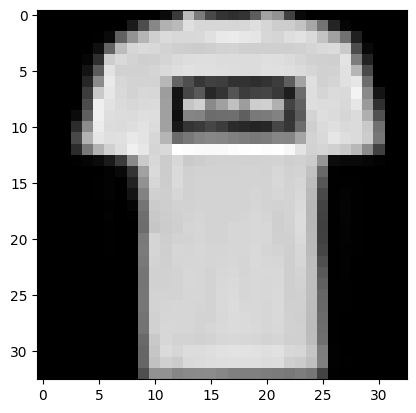

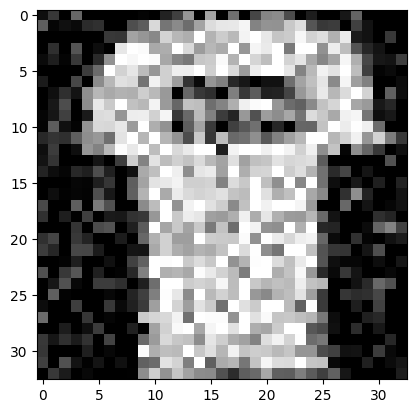

In [8]:
from scipy.misc import face
import matplotlib.pyplot as plt
import torch

instance, label = train_dataset.__getitem__(1)

#print(instance.shape)
plt.imshow(transforms.functional.to_pil_image(instance), cmap="gray")
plt.show()

plt.imshow(transforms.functional.to_pil_image(add_noise(instance, mean=0, sigma=0.2)), cmap="gray")
plt.show()

# Autoencoder Model

In [9]:
class Encoder(nn.Module):
  def __init__(self, channels = [3,10,12,14,16], kernel_size = 3):
    super().__init__()

    self.kernel_size = kernel_size
    self.channels = channels.copy()

    layers = []
    for i in range(len(self.channels) - 1):
      layers.append(nn.Dropout(p=0.1))
      layers.append(nn.Conv2d(self.channels[i], self.channels[i+1], self.kernel_size, stride = 2, padding=int(self.kernel_size/2)))
      layers.append(nn.ReLU())
    #layers[-1] = nn.Tanh()
    self.layers = nn.Sequential(*layers)


  def forward(self, x):
    x = self.layers(x)
    return x

class Decoder(nn.Module):
  def __init__(self, input_size = (3,225,225), channels = [16,14,12,10,3], kernel_size = 3, fc_layer = None):
    super().__init__()

    self.kernel_size = kernel_size
    self.channels = channels.copy()
    self.fc_layer = fc_layer

    self.out_size = list(input_size)[1:]
    for i in range(len(channels)-1):
      self.out_size[0] = int(self.out_size[0]/2)+1
      self.out_size[1] = int(self.out_size[1]/2)+1

    layers = []
    for i in range(len(self.channels) - 1):
      layers.append(nn.Dropout(p=0.1))
      layers.append(nn.ConvTranspose2d(self.channels[i], self.channels[i+1], self.kernel_size, stride = 2, padding=int(self.kernel_size/2)))
      layers.append(nn.ReLU())
    layers[-1] = nn.Sigmoid()
    self.layers = nn.Sequential(*layers)

    if self.fc_layer != None:
      self.dense_layer = nn.Sequential(
          nn.Linear(self.fc_layer, self.out_size[0]*self.out_size[1]*self.channels[0]),
          nn.ReLU(),
        )


  def forward(self, x):
    if self.fc_layer != None:
      b_size, n_features = x.shape
      x = self.dense_layer(x)
      x = x.reshape(b_size, self.channels[0], self.out_size[0], self.out_size[1])

    x = self.layers(x)
    return x

In [10]:
class VAE(nn.Module):
    def __init__(self, input_size = (3,225,225), channels = [3,8,12,16], kernel_size = 5, fc_layer = None):
        super().__init__()

        self.kernel_size = kernel_size
        self.channels = channels
        self.fc_layer = fc_layer
        self.out = None
        self.input_size = input_size

        if self.fc_layer == None:
          self.encoder = Encoder(channels = self.channels[:len(self.channels)-1], kernel_size = self.kernel_size)
          self.channels.reverse()
          self.decoder = Decoder(input_size = self.input_size, channels = self.channels, kernel_size = self.kernel_size, fc_layer = self.fc_layer)
          self.channels.reverse()

          self.mu = nn.Conv2d(self.channels[-2], self.channels[-1], self.kernel_size, stride = 2, padding=int(self.kernel_size/2))
          self.sigma = nn.Conv2d(self.channels[-2], self.channels[-1], self.kernel_size, stride = 2, padding=int(self.kernel_size/2))
        else:

          self.encoder = Encoder(channels = self.channels, kernel_size = self.kernel_size)
          self.channels.reverse()
          self.decoder = Decoder(input_size = self.input_size, channels = self.channels, kernel_size = self.kernel_size, fc_layer = self.fc_layer)
          self.channels.reverse()

          self.out_size = list(input_size)[1:]
          for i in range(len(channels)-1):
            self.out_size[0] = int(self.out_size[0]/2)+1
            self.out_size[1] = int(self.out_size[1]/2)+1

          self.mu = nn.Linear(self.out_size[0]*self.out_size[1]*self.channels[-1], self.fc_layer)
          self.sigma = nn.Linear(self.out_size[0]*self.out_size[1]*self.channels[-1], self.fc_layer)

          self.fc_decode = nn.Linear(self.fc_layer, self.out_size[0]*self.out_size[1]*self.channels[-1])

    def reparameterize(self, mu, log_var):
        """ Reparametrization trick"""
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)  # random sampling happens here
        z = mu + std * eps
        return z

    def forward(self, x):
        b_size, n_channels, h, w = x.shape
        x = self.encoder(x)

        if self.fc_layer != None:
          x = x.reshape(b_size, self.out_size[0]*self.out_size[1]*self.channels[-1])

        mu = self.mu(x)
        log_var = self.sigma(x)
        z = self.reparameterize(mu, log_var)
        #print(z.shape)
        #if self.fc_layer != False:
        #  x = nn.ReLU()(self.fc_decode(z))
        #  x = x.reshape(b_size, self.channels[-1], self.out_size[0], self.out_size[1])

        x = self.decoder(z)

        return x, (z, mu, log_var)


In [11]:
size = 33

model = VAE(input_size = (1,size,size), channels = [3,16,32,48,64], kernel_size = 5, fc_layer = 2)

test_image = torch.ones(32,3,size,size)  # for some reason only works with uneven image size (e.g. for 225 correct, not for 224)

print(test_image.shape)

out, (z, mu, log_var) = model.forward(test_image)
print(mu.shape)
print(out.shape)

print(int(size/2)+1)

torch.Size([32, 3, 33, 33])
torch.Size([32, 2])
torch.Size([32, 3, 33, 33])
17


In [19]:
size = 33

model = VAE(input_size = (1,size,size), channels = [1,16,32,48,64], kernel_size=5, fc_layer = 2)
model.to(device)

VAE(
  (encoder): Encoder(
    (layers): Sequential(
      (0): Dropout(p=0.1, inplace=False)
      (1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
      (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (5): ReLU()
      (6): Dropout(p=0.1, inplace=False)
      (7): Conv2d(32, 48, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (8): ReLU()
      (9): Dropout(p=0.1, inplace=False)
      (10): Conv2d(48, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (11): ReLU()
    )
  )
  (decoder): Decoder(
    (layers): Sequential(
      (0): Dropout(p=0.1, inplace=False)
      (1): ConvTranspose2d(64, 48, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
      (4): ConvTranspose2d(48, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (5): ReLU()
      (6): Dropout(p=0.1, inplace=False)
      (7): Co

In [20]:
print(f"The model has {model_params(model)} parameters.")

The model has 262821 parameters.


In [21]:
def vae_loss_function(recons, target, mu, log_var, lambda_kld=1e-3):
    mu = mu.reshape(recons.shape[0], -1)
    log_var = log_var.reshape(recons.shape[0], -1)
    recons_loss = nn.functional.mse_loss(recons, target)
    kld = (-0.5 * (1 + log_var - mu**2 - log_var.exp()).sum(dim=1)).mean(dim=0)
    loss = recons_loss + lambda_kld * kld

    return loss, (recons_loss, kld)

In [22]:
BATCH_SIZE = 32
SHUFFLE_TRAIN = True
NUM_EPOCHS = 12
LR = 3e-4
EVAL_FREQ = 1
SAVE_FREQ = 2
#OPTI_STEPS = 100


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_TRAIN, num_workers=2)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Test if dataloader loads images in a sensible shape (transfors make sense)

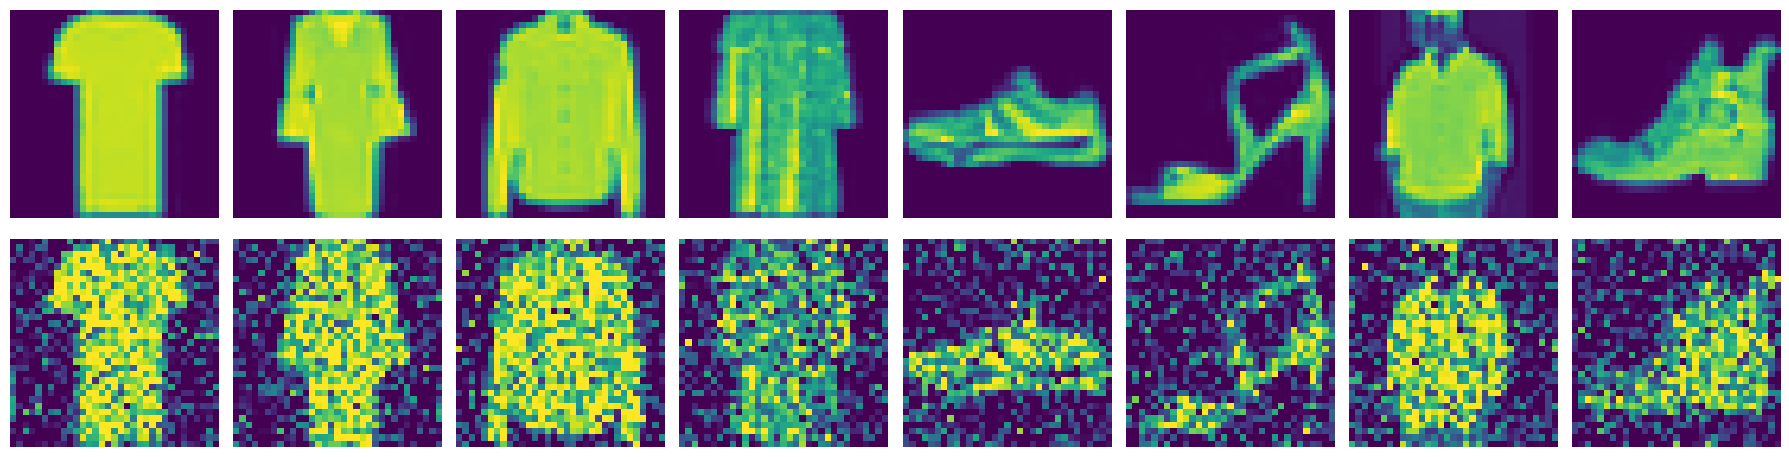

In [23]:
imgs, _ = next(iter(train_loader))
noisy_imgs = add_noise(imgs, sigma=0.3)
fig, ax = plt.subplots(2, 8)
fig.set_size_inches(18, 5)
for i in range(8):
    ax[0, i].imshow(transforms.functional.to_pil_image(imgs[i]))#, cmap="gray")
    ax[0, i].axis("off")
    ax[1, i].imshow(transforms.functional.to_pil_image(noisy_imgs[i]))#, cmap="gray")
    ax[1, i].axis("off")
plt.tight_layout()
plt.show()

In [24]:
# classification loss function
criterion = vae_loss_function #nn.MSELoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Decay LR by a factor of 0.1 every X epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.1, verbose=True)#torch.optim.lr_scheduler.StepLR(optimizer0, step_size=OPTI_STEPS, gahttps://aka.ms/vscode-workspace-trustmma=0.2)

In [25]:
import time
set_random_seed(420)
start_time = time.time()
stats0, model = train(model, NUM_EPOCHS, train_loader, None, val_loader, optimizer, criterion, EVAL_FREQ, SAVE_FREQ, '/content', device, scheduler, twriter = None, loadpath = None, stats = None)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch -1: valid_loss 0.16516


Epoch 1 Iter 1875: loss 0.03336. : 100%|██████████| 1875/1875 [02:10<00:00, 14.35it/s]


Epoch 1: train_loss 0.04167 | valid_loss 0.03197


Epoch 2 Iter 1875: loss 0.03074. : 100%|██████████| 1875/1875 [02:07<00:00, 14.68it/s]


Epoch 2: train_loss 0.03210 | valid_loss 0.03040


Epoch 3 Iter 1875: loss 0.02820. : 100%|██████████| 1875/1875 [02:04<00:00, 15.05it/s]


Epoch 3: train_loss 0.03051 | valid_loss 0.02839


Epoch 4 Iter 1875: loss 0.02723. : 100%|██████████| 1875/1875 [02:08<00:00, 14.58it/s]


Epoch 4: train_loss 0.02950 | valid_loss 0.02798


Epoch 5 Iter 1875: loss 0.03094. : 100%|██████████| 1875/1875 [02:05<00:00, 14.89it/s]


Epoch 5: train_loss 0.02890 | valid_loss 0.02772


Epoch 6 Iter 1875: loss 0.03117. : 100%|██████████| 1875/1875 [02:05<00:00, 14.91it/s]


Epoch 6: train_loss 0.02848 | valid_loss 0.02705


Epoch 7 Iter 1875: loss 0.02996. : 100%|██████████| 1875/1875 [02:05<00:00, 14.89it/s]


Epoch 7: train_loss 0.02818 | valid_loss 0.02701


Epoch 8 Iter 1875: loss 0.02973. : 100%|██████████| 1875/1875 [02:06<00:00, 14.85it/s]


Epoch 8: train_loss 0.02788 | valid_loss 0.02704


Epoch 9 Iter 1875: loss 0.02631. : 100%|██████████| 1875/1875 [02:03<00:00, 15.23it/s]


Epoch 9: train_loss 0.02769 | valid_loss 0.02654


Epoch 10 Iter 1875: loss 0.02548. : 100%|██████████| 1875/1875 [02:04<00:00, 15.08it/s]


Epoch 10: train_loss 0.02752 | valid_loss 0.02635


Epoch 11 Iter 1875: loss 0.02437. : 100%|██████████| 1875/1875 [02:04<00:00, 15.10it/s]


Epoch 11: train_loss 0.02741 | valid_loss 0.02628


Epoch 12 Iter 1875: loss 0.02531. : 100%|██████████| 1875/1875 [02:03<00:00, 15.19it/s]


Epoch 12: train_loss 0.02728 | valid_loss 0.02596
--- 1619.6405954360962 seconds ---


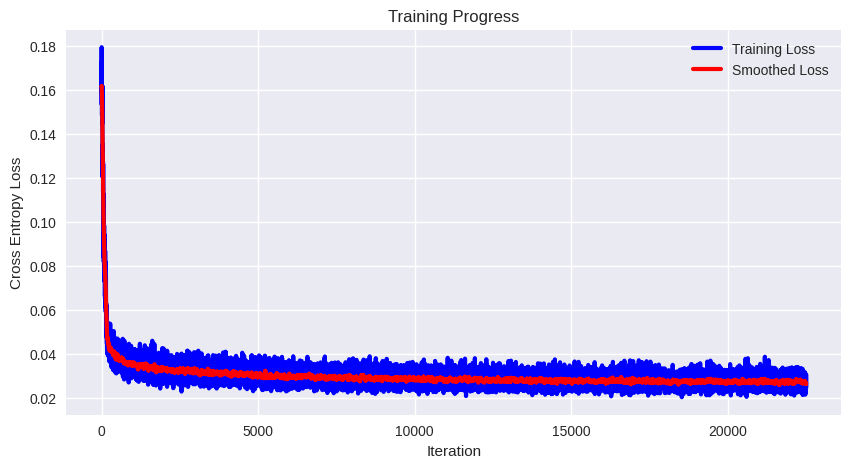

In [26]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,5)

smooth_loss = smooth(stats0["per_batch_loss"], 31)
ax.plot(stats0["per_batch_loss"], c="blue", label="Training Loss", linewidth=3)#, alpha=0.5)
ax.plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3)
ax.legend(loc="best")
ax.set_xlabel("Iteration")
ax.set_ylabel("Cross Entropy Loss")
ax.set_title("Training Progress")

plt.show()

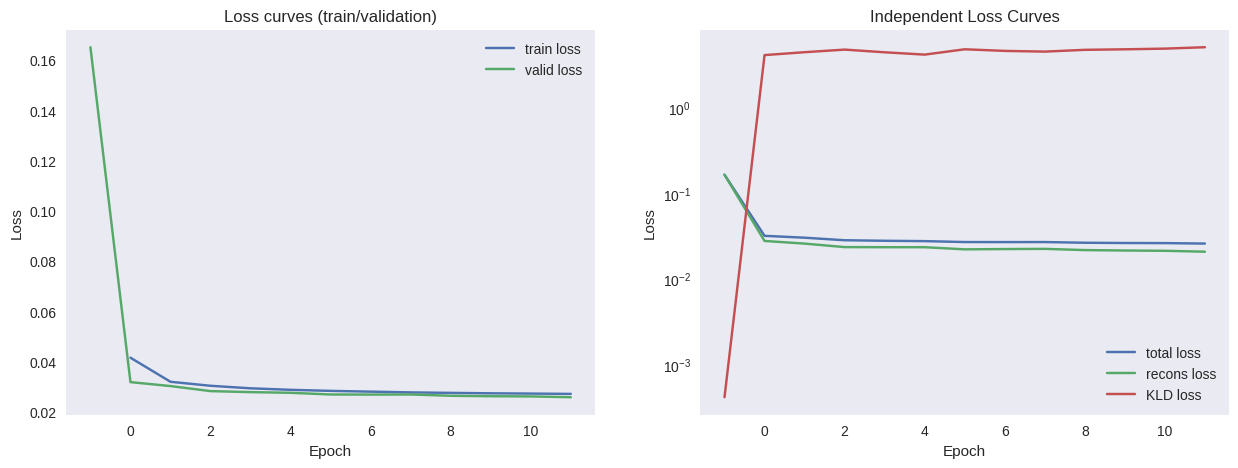

In [27]:
eval_plots(model, val_loader, criterion, device, stats0)

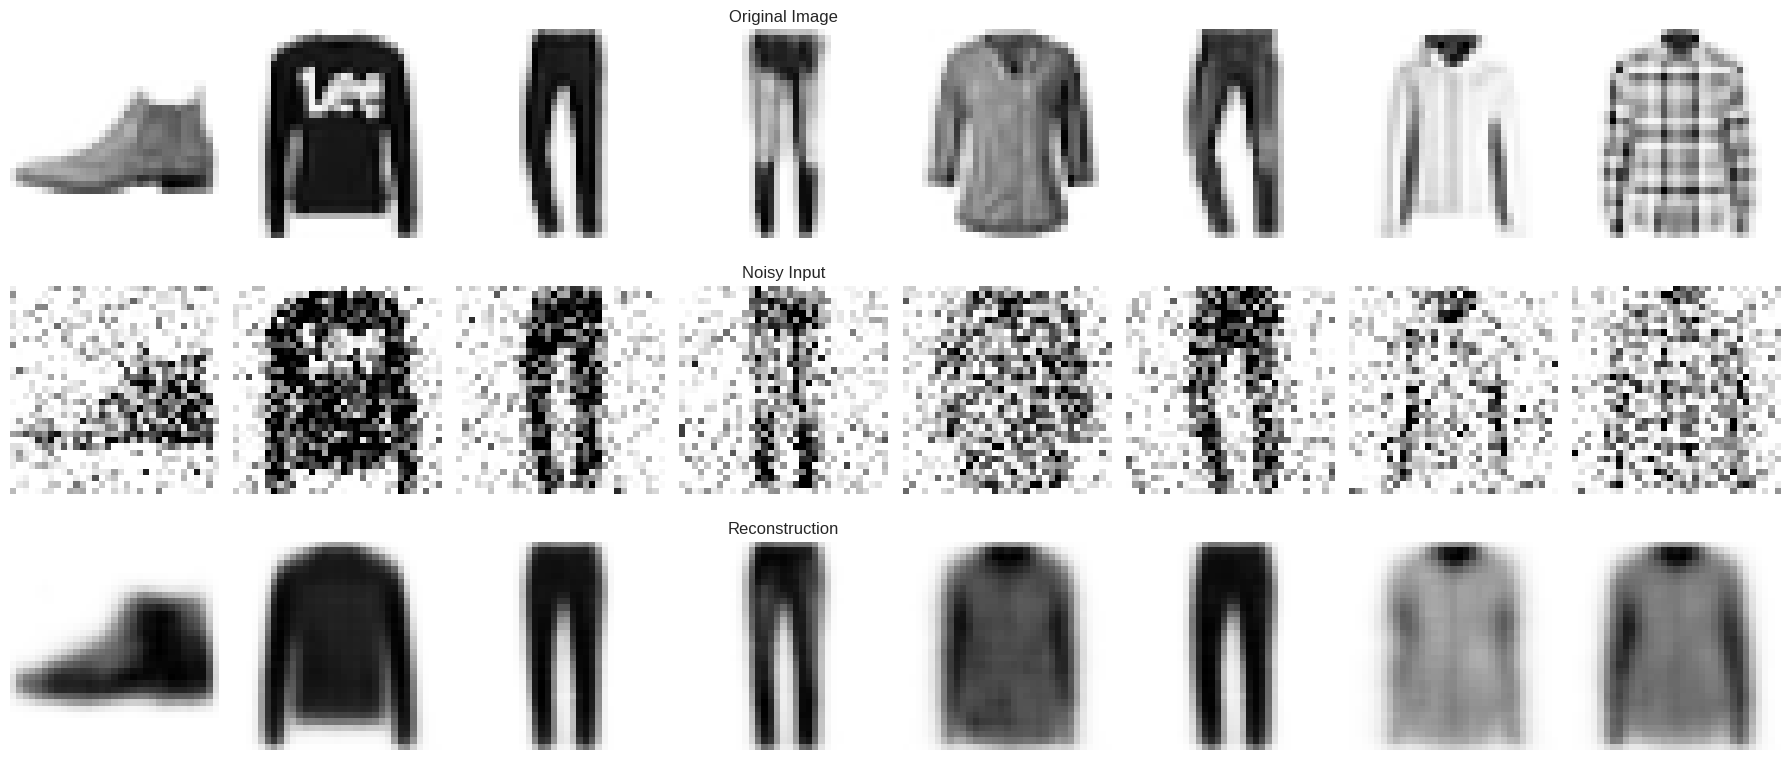

In [28]:
imgs, _ = next(iter(val_loader))
noisy_imgs = add_noise(imgs, sigma=0.3)

model.eval()
with torch.no_grad():
    recons, _ = model(noisy_imgs.to(device))

fig, ax = plt.subplots(3, 8)
fig.set_size_inches(18, 8)
for i in range(8):
    ax[0, i].imshow(transforms.functional.to_pil_image(imgs[i]))
    ax[0, i].axis("off")
    ax[1, i].imshow(transforms.functional.to_pil_image(noisy_imgs[i]))
    ax[1, i].axis("off")
    ax[2, i].imshow(transforms.functional.to_pil_image(recons[i].cpu()))
    ax[2, i].axis("off")

ax[0, 3].set_title("Original Image")
ax[1, 3].set_title("Noisy Input")
ax[2, 3].set_title("Reconstruction")
plt.tight_layout()
plt.show()

Analysis

In [29]:
from sklearn.decomposition import PCA

In [30]:
COLORS = ['r', 'b', 'g', 'y', 'purple', 'orange', 'k', 'brown', 'grey',
          'c', "gold", "fuchsia", "lime", "darkred", "tomato", "navy"]

def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """

    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    #print(legend)
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(6,6))

    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)
        ax.scatter(points[idx, 0], points[idx, 1])#, label=legend[int(l)], c=COLORS[i])
    #ax.legend(loc="best")

In [31]:
imgs_flat, latents, labels = [], [], []
with torch.no_grad():
    for imgs, lbls in val_loader:
        imgs = imgs.to(device)
        _, (z, _, _) = model(imgs)
        #imgs_flat.append(imgs.cpu().view(imgs.shape[0],-1))
        latents.append(z.cpu())
        labels.append(lbls)

#imgs_flat = np.concatenate(imgs_flat)
latents = np.concatenate(latents)
labels = np.concatenate(labels)

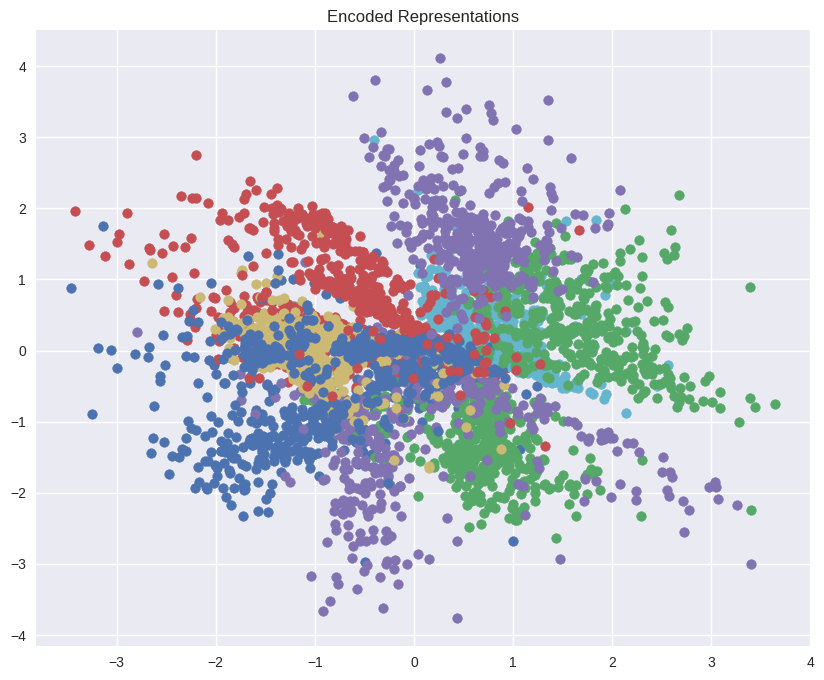

In [32]:
#pca_imgs = PCA(n_components=2).fit_transform(imgs_flat)

N = 4000

pca_latents = PCA(n_components=2).fit_transform(latents[:N])

fig,ax = plt.subplots(1,1,figsize=(10,8))
#display_projections(pca_imgs[:N], labels[:N], ax=ax[0], legend=None)
#ax[0].set_title("PCA Proj. of Images")
display_projections(pca_latents[:N], labels[:N], ax=ax, legend=None)
ax.set_title("Encoded Representations")
plt.show()

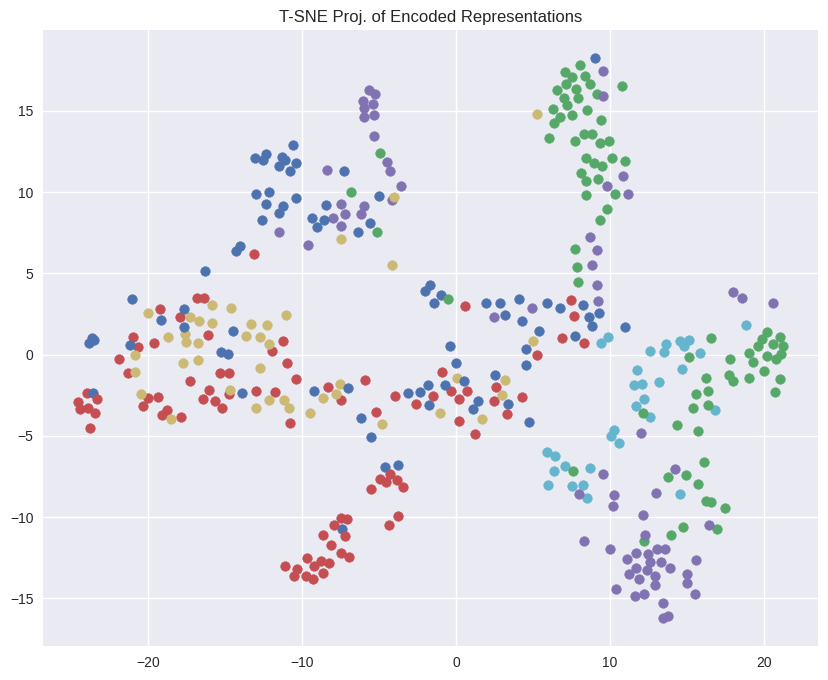

In [33]:
from sklearn.manifold import TSNE

N = 400
#tsne_imgs = TSNE(n_components=2).fit_transform(imgs_flat[:N])
tsne_latents = TSNE(n_components=2).fit_transform(latents[:N])

fig,ax = plt.subplots(1,1,figsize=(10,8))
#display_projections(tsne_imgs[:N], labels[:N], ax=ax[0], legend=test_dataset.classes)
#ax[0].set_title("T-SNE Proj. of Images")
display_projections(tsne_latents[:N], labels[:N], ax=ax, legend=None)
ax.set_title("T-SNE Proj. of Encoded Representations")
plt.show()

## Inference


In [35]:
if not os.path.exists("imgs/inferecence_vae"):
    os.makedirs("imgs/inferecence_vae")

In [36]:
from torchvision.utils import save_image

with torch.no_grad():
    for i in range(5):
        z = torch.randn(64, 2).to(device)
        sample = model.decoder(z)
        save_image(sample.view(64, 1, 33, 33), f"imgs/inferecence_vae/inference_{i}.png")

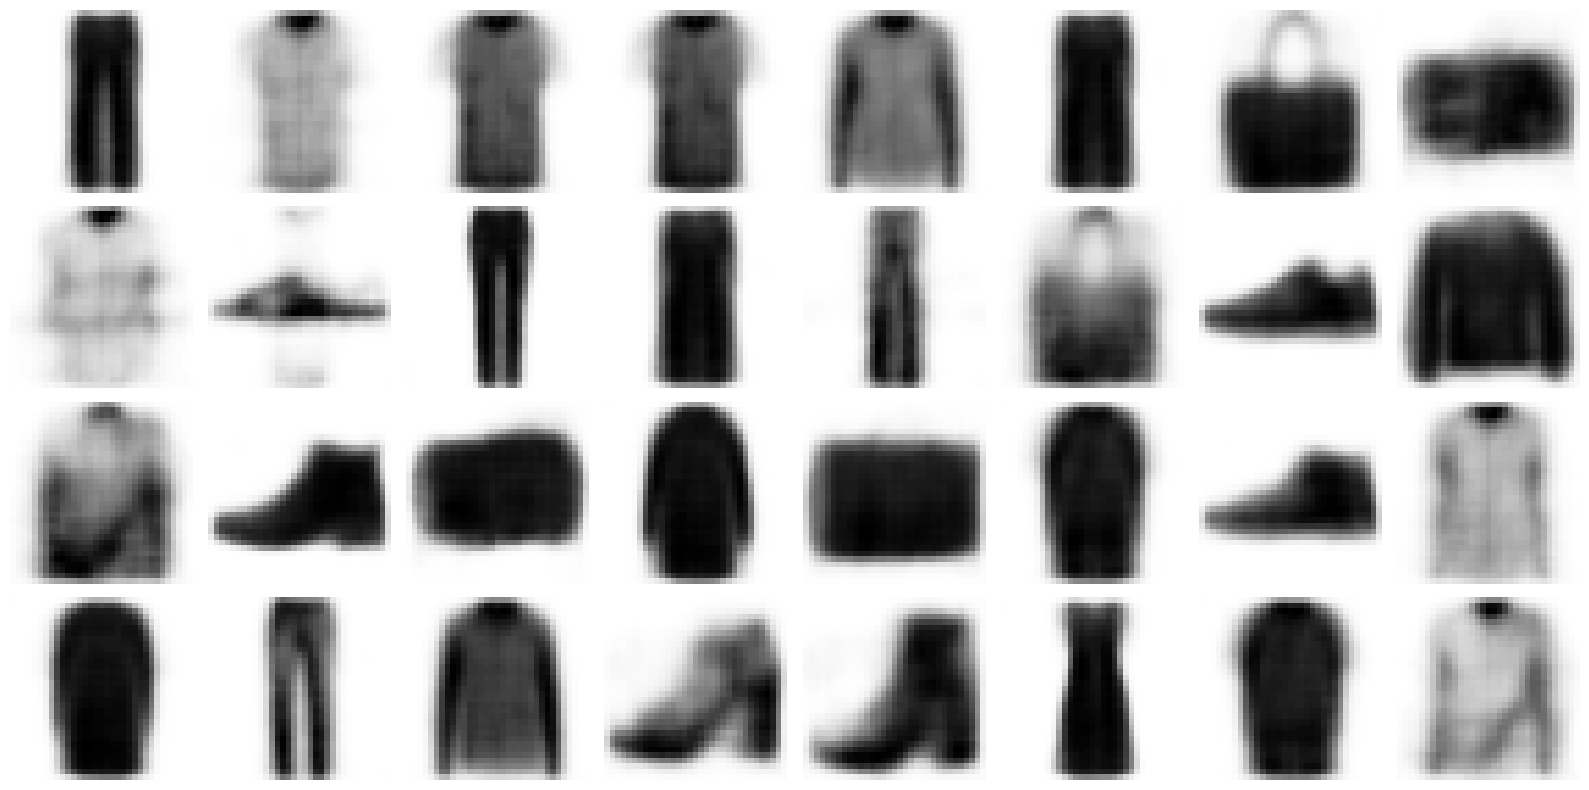

In [37]:
recons = sample.view(64, 1, 33, 33)
plt.figure(figsize=(8*2, 4*2))
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.imshow(transforms.functional.to_pil_image(recons[i].cpu()))#, cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

## Interpolation

In [39]:


@torch.no_grad()
def plot_reconstructed(model, xrange=(-3, 3), yrange=(-2, 2), N=12):
    """
    Sampling equispaced points from the latent space givent the xange and yrange,
    decoding latents and visualizing distribution of the space
    """
    SIZE = 33
    grid = np.empty((1,N*SIZE, N*SIZE))

    for i, y in enumerate(np.linspace(*yrange, N)):
        for j, x in enumerate(np.linspace(*xrange, N)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = model.decoder(z).cpu()
            x_hat = x_hat.view(1, 33,33)

            #if np.random.randint(0, high=2) == 1:
            #  x_hat = torch.zeros(3,257,257)

            grid[:,(N-1-i)*SIZE:(N-i)*SIZE, j*SIZE:(j+1)*SIZE] = x_hat

    grid = torch.tensor(grid)

    plt.figure(figsize=(12,20))
    plt.imshow(transforms.functional.to_pil_image(grid), extent=[*yrange, *xrange])#, cmap="gray")
    plt.axis("off")

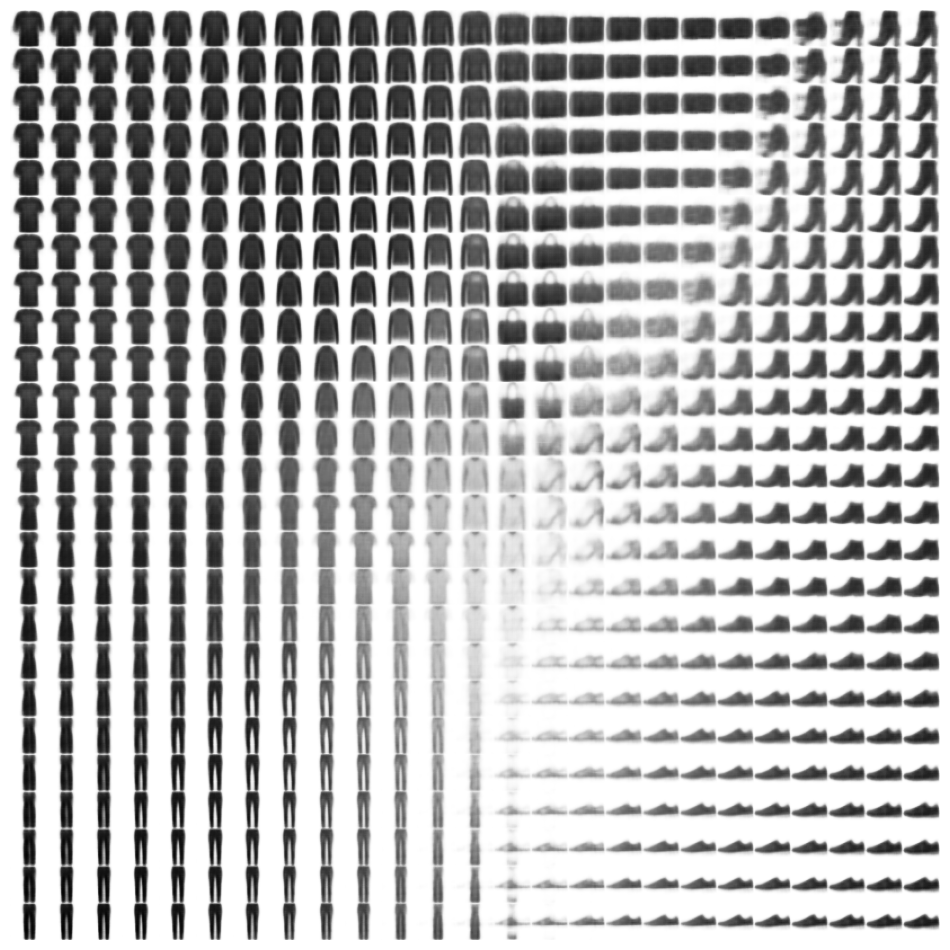

In [41]:
plot_reconstructed(model, xrange=(-2, 2), yrange=(-2, 2), N=25)

Interpolate between two images.

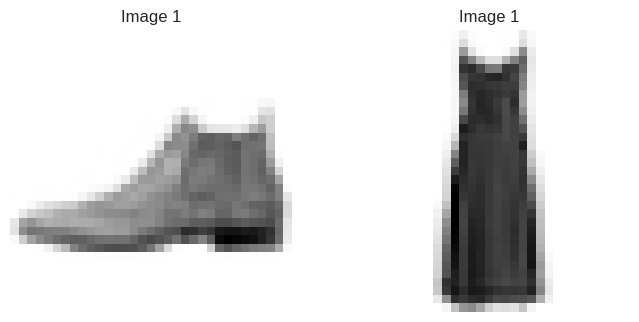

In [42]:
img1 = test_dataset[0][0]
img2 = test_dataset[13][0]

plt.subplot(1,2,1)
plt.imshow(transforms.functional.to_pil_image(img1))
plt.axis("off")
plt.title(f"Image 1")
plt.subplot(1,2,2)
plt.imshow(transforms.functional.to_pil_image(img2))
plt.axis("off")
plt.title(f"Image 1")
plt.show()

In [43]:
with torch.no_grad():
    encoded = model.encoder(torch.stack([img1, img2]).to(device))
    b_size, n_channels, w, h = encoded.shape
    encoded = encoded.reshape(b_size, n_channels*w*h)
    mus, log_var = model.mu(encoded), model.sigma(encoded)
std = torch.exp(0.5*log_var)
latents = mus + std
latent1, latent2 = latents[0], latents[1]

In [45]:
@torch.no_grad()
def sample_interpolation(model, p1, p2, N=15):
    """ Sampling N points from the line that connects p1 and p2 """

    z = torch.stack([p1 * t + p2 * (1-t) for t in torch.linspace(0, 1, N).to(device)])
    decoded = model.decoder (z)
    decoded_imgs = decoded.cpu().view(-1,1,33,33)
    return decoded_imgs

In [46]:
decoded_imgs = sample_interpolation(model, latent2, latent1, N=12)

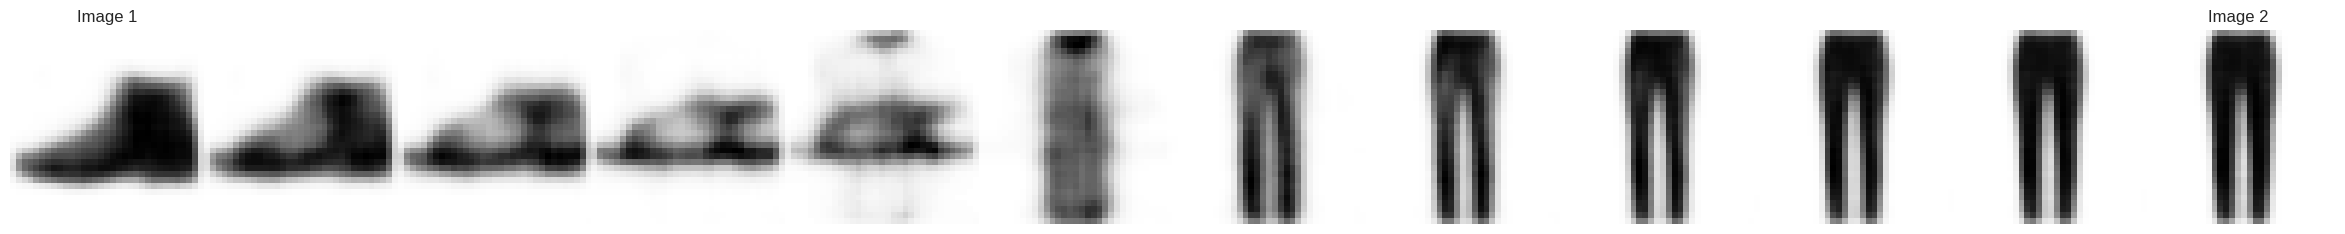

In [47]:
fig, ax = plt.subplots(1, len(decoded_imgs), figsize=(30,3))
for i,img in enumerate(decoded_imgs):
    ax[i].imshow(transforms.functional.to_pil_image(img))#, cmap="gray")
    ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.subplots_adjust(wspace=0., hspace=0)
ax[0].set_title("Image 1")
ax[-1].set_title("Image 2")
plt.show()